In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
import warnings
warnings.filterwarnings('ignore')
import pandas_profiling as pp
import seaborn as sns
import matplotlib as plt
%matplotlib inline

In [2]:
from zipfile import ZipFile
with ZipFile("blogs.zip",'r') as zObj:
 zObj.extractall()

In [3]:
#reading the Data
blog_df = pd.read_csv("blogtext.csv")

In [4]:
#Shape of data
blog_df.shape

(681284, 7)

In [5]:
#print first five rows
blog_df.sample(5)

id  gender  age       topic         sign              date  \
585978   944569  female   14     Student          Leo     03,March,2003   
301138  1645698    male   26     Student       Taurus  12,December,2003   
466500  2542729    male   26  Technology      Scorpio     09,April,2004   
274783  4018737  female   23     Science  Sagittarius    13,August,2004   
629972  3539470  female   36      indUnk        Virgo      07,June,2004   

                                                     text  
585978             You suck David..This is not a piece...  
301138             If you park, don't drink.  Accident...  
466500               WE'RE LEAVING!!! AHHAHAHAHAHAA!! ...  
274783                Me? I've made 210 .... and I've ...  
629972         It's nearly 9 p.m. and I'm tuckered! It...

In [6]:
#Limiting the data and using fewer rows as the data size is large
#blog_df = blog_df.head(100000)

blog_df = pd.read_csv("blogtext.csv",nrows=2000)
blog_df.head()

id gender  age              topic      sign          date  \
0  2059027   male   15            Student       Leo   14,May,2004   
1  2059027   male   15            Student       Leo   13,May,2004   
2  2059027   male   15            Student       Leo   12,May,2004   
3  2059027   male   15            Student       Leo   12,May,2004   
4  3581210   male   33  InvestmentBanking  Aquarius  11,June,2004   

                                                text  
0             Info has been found (+/- 100 pages,...  
1             These are the team members:   Drewe...  
2             In het kader van kernfusie op aarde...  
3                   testing!!!  testing!!!            
4               Thanks to Yahoo!'s Toolbar I can ...

In [7]:
#check if the last 5 rows of the data frame using the tail() method
blog_df.tail()

id gender  age       topic   sign            date  \
1995  589736   male   35  Technology  Aries  05,August,2004   
1996  589736   male   35  Technology  Aries  05,August,2004   
1997  589736   male   35  Technology  Aries  05,August,2004   
1998  589736   male   35  Technology  Aries  05,August,2004   
1999  589736   male   35  Technology  Aries  05,August,2004   

                                                   text  
1995             Mir...*lmao*...  Too funny. :)     ...  
1996             as you read this section of the art...  
1997             i guess the same could have been as...  
1998             For the PC gamers out there:   urlL...  
1999             WTF.   urlLink Michael Jackson dang...

In [8]:
#get more information about data
blog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   gender  2000 non-null   object
 2   age     2000 non-null   int64 
 3   topic   2000 non-null   object
 4   sign    2000 non-null   object
 5   date    2000 non-null   object
 6   text    2000 non-null   object
dtypes: int64(2), object(5)
memory usage: 109.5+ KB


In [9]:
# Count Values of column gender
blog_df.gender.value_counts()

male      1272
female     728
Name: gender, dtype: int64

<AxesSubplot:xlabel='gender', ylabel='count'>

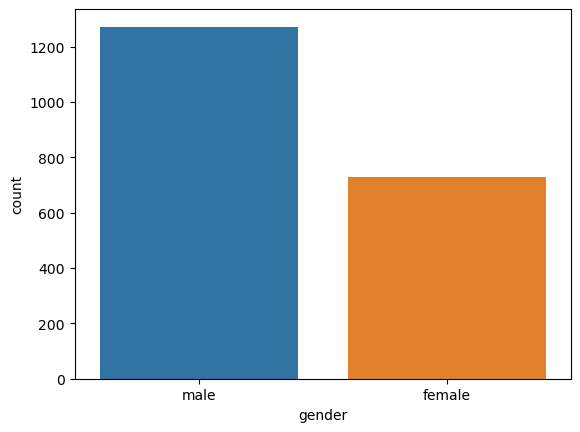

In [10]:
sns.countplot(x='gender',data=blog_df)

In [11]:
#checking null values 
blog_df.isna().sum()

id        0
gender    0
age       0
topic     0
sign      0
date      0
text      0
dtype: int64

2. Preprocess unstructured data to make it consumable for model training.

 A. Eliminate All special Characters and Numbers 

 B. Lowercase all textual data 

 C. Remove all Stopwords 

 D. Remove all extra white spaces 

In [12]:
# remove unwanted chars other than alphanumeric
pattern = "[^\w ]"
blog_df.text = blog_df.text.apply(lambda s : re.sub(pattern,"",s))

In [13]:
#remove unwanted spaces
blog_df.text = blog_df.text.apply(lambda s: s.strip())

In [14]:
# Convert text to lowercase
blog_df.text = blog_df.text.apply(lambda x: x.lower())

In [15]:
import nltk
nltk.download('stopwords')

# Remove stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
blog_df.text = blog_df.text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

[nltk_data] Downloading package stopwords to C:\Users\Sandeep
[nltk_data]     Basetty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
blog_df.head()

id gender  age              topic      sign          date  \
0  2059027   male   15            Student       Leo   14,May,2004   
1  2059027   male   15            Student       Leo   13,May,2004   
2  2059027   male   15            Student       Leo   12,May,2004   
3  2059027   male   15            Student       Leo   12,May,2004   
4  3581210   male   33  InvestmentBanking  Aquarius  11,June,2004   

                                                text  
0  info found 100 pages 45 mb pdf files wait unti...  
1  team members drewes van der laag urllink mail ...  
2  het kader van kernfusie op aarde maak je eigen...  
3                                    testing testing  
4  thanks yahoos toolbar capture urls popupswhich...

3. Build a base Classification model [8 Marks]

 A. Create dependent and independent variables [2 Marks]
 Hint: Treat ‘topic’ as a Target variable.
    
 B. Split data into train and test. [1 Marks]

 C. Vectorize data using any one vectorizer. [2 Marks]

 D. Build a base model for Supervised Learning - Classification. [2 Marks]
 
 E. Clearly print Performance Metrics. [1 Marks]
 Hint: Accuracy, Precision, Recall, ROC-AUC

In [17]:
# drop id and date columns
blog_df.drop(labels=['id','date'], axis=1,inplace=True)

In [18]:
blog_df['labels'] = blog_df.apply(lambda col : [col['gender'],col['age'],col['topic'],col['sign']], axis=1)

In [19]:
#drop  gender,age,topic & sign as they are already merged to labels column
blog_df.drop(columns=['gender','age','topic','sign'], axis=1, inplace=True)

In [20]:
blog_df.head()

text  \
0  info found 100 pages 45 mb pdf files wait unti...   
1  team members drewes van der laag urllink mail ...   
2  het kader van kernfusie op aarde maak je eigen...   
3                                    testing testing   
4  thanks yahoos toolbar capture urls popupswhich...   

                                    labels  
0                 [male, 15, Student, Leo]  
1                 [male, 15, Student, Leo]  
2                 [male, 15, Student, Leo]  
3                 [male, 15, Student, Leo]  
4  [male, 33, InvestmentBanking, Aquarius]

In [21]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
def lemmafun(text):
  text = [lemmatizer.lemmatize(word)for word in text.split()]
  return " ".join(text)

[nltk_data] Downloading package wordnet to C:\Users\Sandeep
[nltk_data]     Basetty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
blog_df['text'] = blog_df['text'].apply(lemmafun)
blog_df.head(5)

text  \
0  info found 100 page 45 mb pdf file wait untill...   
1  team member drewes van der laag urllink mail r...   
2  het kader van kernfusie op aarde maak je eigen...   
3                                    testing testing   
4  thanks yahoo toolbar capture url popupswhich m...   

                                    labels  
0                 [male, 15, Student, Leo]  
1                 [male, 15, Student, Leo]  
2                 [male, 15, Student, Leo]  
3                 [male, 15, Student, Leo]  
4  [male, 33, InvestmentBanking, Aquarius]

In [23]:
# Check the colwidth 
#pd.options.display.max_colwidth
# resize
#pd.options.display.max_colwidth = 120

# Setting it to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
     

In [24]:
#Stemming operation bundles together words of same root. E.g. stem operation bundles "response" and "respond" into a common "respon".
#A funtion to carry out stemming operation
# create an object of stemming function


from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

In [25]:
#Apply the function to each examples
blog_df['text'] = blog_df['text'].apply(stemming)
blog_df.head(10)
     

text  \
0  info found 100 page 45 mb pdf file wait until team leader process learn html                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [26]:
X= blog_df.text
y = blog_df.labels

In [27]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2,test_size = 0.2)

In [28]:
print(X_train.shape)
print(y_train.shape)

(1600,)
(1600,)


In [29]:
print(X_test.shape)
print(y_test.shape)

(400,)
(400,)


In [30]:
X_test

278     read found pretti sad kid want go kill muslim that kill muslim god hope dont let branch arm forc need kid muslim kill agenda sad mani level even funni normal someon get mad thing like immigr peopl race most fear drive normal fear peopl arent actual inferior thing well mani time hear high skill peopl go immigr problemsnot alot know secur job arent afraid someon isnt acclim cultur cant speak languag well go come take job away far im concern replac someon cant speak english got probabl didnt deserv job first place also love peopl talk want unfett capit laissez fair govern also peopl hate illeg im sorri cant go glori free market one minut talk shit peopl live express next illeg work harder le money countri go shit get job risk far thanani u ever come first place embodi free market capit risk everyth shot better life will work hard cheap fruit veget dont hear anyon complain never hear anyon say damn illeg orang cost 10 time much funni part countri support illeg everi day buy fruit c

In [31]:
cvect = CountVectorizer(ngram_range=(1,2))

In [32]:
#Feed SMS data to CountVectorizer
cvect.fit(X_train)

#Check the vocablury size
len(cvect.vocabulary_)

153307

In [33]:
cvect.get_feature_names_out()

array(['000', '000 peopl', '0000', ..., '한방삼계탕 hanbangsamgyetang', '회식',
       '회식 hwishik'], dtype=object)

In [34]:
X_train_ct = cvect.transform(X_train)

In [35]:
X_train_ct[0]

<1x153307 sparse matrix of type '<class 'numpy.int64'>'
	with 192 stored elements in Compressed Sparse Row format>

In [36]:
X_test_ct = cvect.transform(X_test)

In [37]:
X_test_ct

<400x153307 sparse matrix of type '<class 'numpy.int64'>'
	with 36390 stored elements in Compressed Sparse Row format>

In [38]:
cvect.get_feature_names_out()[:10]

array(['000', '000 peopl', '0000', '0000 blink', '007', '007 game', '01',
       '01 known', '01 role', '010203'], dtype=object)

In [39]:
label_counts=dict()

for labels in blog_df.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[str(label)]+=1
        else:
            label_counts[str(label)]=1

In [40]:
label_counts

{'male': 1272,
 '15': 1,
 'Student': 403,
 'Leo': 55,
 '33': 1,
 'InvestmentBanking': 70,
 'Aquarius': 286,
 'female': 728,
 '14': 1,
 'indUnk': 452,
 'Aries': 699,
 '25': 1,
 'Capricorn': 77,
 '17': 1,
 'Gemini': 21,
 '23': 1,
 'Non-Profit': 46,
 'Cancer': 76,
 'Banking': 16,
 '37': 1,
 'Sagittarius': 113,
 '26': 1,
 '24': 1,
 'Scorpio': 243,
 '27': 1,
 'Education': 118,
 '45': 1,
 'Engineering': 119,
 'Libra': 313,
 'Science': 33,
 '34': 1,
 '41': 1,
 'Communications-Media': 14,
 'BusinessServices': 21,
 'Sports-Recreation': 75,
 'Virgo': 39,
 'Taurus': 76,
 'Arts': 2,
 'Pisces': 2,
 '44': 1,
 '16': 1,
 'Internet': 20,
 'Museums-Libraries': 2,
 'Accounting': 2,
 '39': 1,
 '35': 1,
 'Technology': 607}

In [41]:
from sklearn.preprocessing import MultiLabelBinarizer
binarizer=MultiLabelBinarizer(classes=sorted(label_counts.keys()))

In [42]:
y_train = binarizer.fit_transform(y_train)

In [43]:
y_test = binarizer.transform(y_test)

In [44]:
y_test

array([[0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [45]:
y_train

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

Design, train, tune and test the best text classifier.

In [46]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [47]:
model=LogisticRegression(solver='lbfgs', max_iter=100)
model=OneVsRestClassifier(model)


In [48]:
model.fit(X_train_ct,y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [49]:
Y_pred=model.predict(X_test_ct)

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def display_metrics_micro(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: Micro', f1_score(Ytest, Ypred, average='micro'))
    print('Average precision score: Micro', average_precision_score(Ytest, Ypred, average='micro'))
    print('Average recall score: Micro', recall_score(Ytest, Ypred, average='micro'))
    
    
def display_metrics_macro(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: Macro', f1_score(Ytest, Ypred, average='macro'))
    print('Average recall score: MAcro', recall_score(Ytest, Ypred, average='macro'))
    
def display_metrics_weighted(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: weighted', f1_score(Ytest, Ypred, average='weighted'))
    print('Average precision score: weighted', average_precision_score(Ytest, Ypred, average='weighted'))
    print('Average recall score: weighted', recall_score(Ytest, Ypred, average='weighted'))

In [51]:
display_metrics_micro(y_test,Y_pred)

Accuracy score:  0.34
F1 score: Micro 0.6639798488664986
Average precision score: Micro 0.4897967655960609
Average recall score: Micro 0.5491666666666667


In [52]:
display_metrics_macro(y_test,Y_pred)

Accuracy score:  0.34
F1 score: Macro 0.20785658297477874
Average recall score: MAcro 0.16974505235698992


In [53]:
display_metrics_weighted(y_test,Y_pred)

Accuracy score:  0.34
F1 score: weighted 0.6273074854450738
Average precision score: weighted 0.5641729774337271
Average recall score: weighted 0.5491666666666667


4. Improve Performance of model. [14 Marks]

A. Experiment with other vectorisers. [4 Marks]

B. Build classifier Models using other algorithms than base model. [4 Marks]

C. Tune Parameters/Hyperparameters of the model/s. [4 Marks]

D. Clearly print Performance Metrics. [2 Marks]
Hint: Accuracy, Precision, Recall, ROC-AUC

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create the transform
tfidf = TfidfVectorizer(stop_words= 'english')
# tokenize and build vocab
tfidf.fit(X_train)
# summarize
#print(tfidf.vocabulary_)
#print(tfidf.idf_)

TfidfVectorizer(stop_words='english')

In [55]:
len(tfidf.vocabulary_)

19458

In [56]:
len(tfidf.idf_)

19458

In [57]:
tfidf.get_feature_names_out()

array(['000', '0000', '007', ..., '푸하하하', '한방삼계탕', '회식'], dtype=object)

In [58]:
# encode document
X_train_tfidf = tfidf.transform(X_train)
# summarize encoded vector
print(X_train_tfidf.shape)
#print(vector.toarray())

(1600, 19458)


In [59]:
x3 = X_train_tfidf
x3

<1600x19458 sparse matrix of type '<class 'numpy.float64'>'
	with 109728 stored elements in Compressed Sparse Row format>

In [60]:
X_test_tfidf  = tfidf.transform(X_test)
print(X_test_tfidf.shape)

(400, 19458)


In [61]:
x4 = X_test_tfidf
x4

<400x19458 sparse matrix of type '<class 'numpy.float64'>'
	with 23862 stored elements in Compressed Sparse Row format>

In [62]:
tfidf.get_feature_names_out()[:10]

array(['000', '0000', '007', '01', '010203', '011', '012', '01234', '02',
       '020031'], dtype=object)

In [63]:
label_counts=dict()

for labels in blog_df.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[str(label)]+=1
        else:
            label_counts[str(label)]=1

In [64]:
label_counts

{'male': 1272,
 '15': 1,
 'Student': 403,
 'Leo': 55,
 '33': 1,
 'InvestmentBanking': 70,
 'Aquarius': 286,
 'female': 728,
 '14': 1,
 'indUnk': 452,
 'Aries': 699,
 '25': 1,
 'Capricorn': 77,
 '17': 1,
 'Gemini': 21,
 '23': 1,
 'Non-Profit': 46,
 'Cancer': 76,
 'Banking': 16,
 '37': 1,
 'Sagittarius': 113,
 '26': 1,
 '24': 1,
 'Scorpio': 243,
 '27': 1,
 'Education': 118,
 '45': 1,
 'Engineering': 119,
 'Libra': 313,
 'Science': 33,
 '34': 1,
 '41': 1,
 'Communications-Media': 14,
 'BusinessServices': 21,
 'Sports-Recreation': 75,
 'Virgo': 39,
 'Taurus': 76,
 'Arts': 2,
 'Pisces': 2,
 '44': 1,
 '16': 1,
 'Internet': 20,
 'Museums-Libraries': 2,
 'Accounting': 2,
 '39': 1,
 '35': 1,
 'Technology': 607}

In [65]:
import sklearn


In [66]:
model1=sklearn.svm.SVC(kernel='linear')
model1=OneVsRestClassifier(model1)

In [67]:
model1.fit(x3,y_train)

OneVsRestClassifier(estimator=SVC(kernel='linear'))

In [68]:
Y_pred1=model1.predict(x4)

In [69]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def display_metrics_micro(Ytest, Ypred1):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred1))
    print('F1 score: Micro', f1_score(Ytest, Ypred1, average='micro'))
    print('Average precision score: Micro', average_precision_score(Ytest, Ypred1, average='micro'))
    print('Average recall score: Micro', recall_score(Ytest, Ypred1, average='micro'))
    
    
def display_metrics_macro(Ytest, Ypred1):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred1))
    print('F1 score: Macro', f1_score(Ytest, Ypred1, average='macro'))
    print('Average recall score: MAcro', recall_score(Ytest, Ypred1, average='macro'))
    
def display_metrics_weighted(Ytest, Ypred1):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred1))
    print('F1 score: weighted', f1_score(Ytest, Ypred1, average='weighted'))
    print('Average precision score: weighted', average_precision_score(Ytest, Ypred1, average='weighted'))
    print('Average recall score: weighted', recall_score(Ytest, Ypred1, average='weighted'))

In [70]:
display_metrics_micro(y_test,Y_pred1)

Accuracy score:  0.1625
F1 score: Micro 0.5049140049140051
Average precision score: Micro 0.3708641131437662
Average recall score: Micro 0.3425


In [71]:
display_metrics_macro(y_test,Y_pred1)

Accuracy score:  0.1625
F1 score: Macro 0.1409485700100305
Average recall score: MAcro 0.10114759609473609


In [72]:
display_metrics_weighted(y_test,Y_pred1)

Accuracy score:  0.1625
F1 score: weighted 0.46944538177732764
Average precision score: weighted 0.5065207246704906
Average recall score: weighted 0.3425


5. Share insights on relative performance comparison [8 Marks]

A. Which vectorizer performed better? Probable reason?.
[2 Marks]

B. Which model outperformed? Probable reason? [2 Marks]

C. Which parameter/hyperparameter significantly helped
to improve performance?Probable reason?. [2 Marks]

D. According to you, which performance metric should be
given most importance, why?. [2 Marks]

comparing to both CountVectorizer and  TfidfVectorizer.
CountVectorizer simply counts the number of times a word appears in a document (using a bag-of-words approach), while TF-IDF Vectorizer takes into account not only how many times a word appears in a document but also how important that word is to the whole corpus.so tfidfVectorizer is performed well and good

done with logistic regression and support vector machine(svm). comparing to both models logistic regression is better at it got the accuracy score more than the svm model.

comparing to both the metric in logistric regression and svm model

The f1-score is more in logistric regression model than the svm 
f1-score : A good F1 score means that you have low false positives and low false negatives, so you're correctly identifying real threats and you are not disturbed by false alarms. An F1 score is considered perfect when it's 1 , while the model is a total failure when it's 0 .

Macro-averaged : Combining the per-class F1-scores into a single number, the classifier’s overall F1-score. There are a few ways of doing that. Let’s begin with the simplest one: an arithmetic mean of the per-class F1-scores. This is called the macro-averaged F1-score, or the macro-F1 for short, and is computed as a simple arithmetic mean of our per-class F1-scores:

the macro-averaged is more in logistic regression than that if compared to that of svm model

Weighted Ang: When averaging the macro-F1, we gave equal weights to each class. We don’t have to do that: in weighted-average F1-score, or weighted-F1, we weight the F1-score of each class by the number of samples from that class

Micro Average: The last variant is the micro-averaged F1-score, or the micro-F1. To calculate the micro-F1, we first compute micro-averaged precision and micro-averaged recall over all the samples , and then combine the two. How do we “micro-average”? We simply look at all the samples together. Remember that precision is the proportion of True Positives out of the Predicted Positives (TP/(TP+FP)). In the multi-class case, we consider all the correctly predicted samples to be True Positives


<font size=4>Part-B</font>

In [73]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open(r'GL Bot.json').read()
intents = json.loads(data_file)

In [74]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Sandeep
[nltk_data]     Basetty\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [75]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Sandeep
[nltk_data]     Basetty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [76]:
for intent in intents['intents']:
    for pattern in intent['patterns']:
        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))
        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [77]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to C:\Users\Sandeep
[nltk_data]     Basetty\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [78]:
# lemmatize, lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

128 documents
8 classes ['Bot', 'Exit', 'Intro', 'NN', 'Olympus', 'Profane', 'SL', 'Ticket']
158 unique lemmatized words ['a', 'able', 'access', 'activation', 'ada', 'adam', 'aifl', 'aiml', 'am', 'an', 'ann', 'anyone', 'are', 'artificial', 'backward', 'bad', 'bagging', 'batch', 'bayes', 'belong', 'best', 'blended', 'bloody', 'boosting', 'bot', 'buddy', 'classification', 'contact', 'create', 'cross', 'cya', 'day', 'deep', 'did', 'diffult', 'do', 'ensemble', 'epoch', 'explain', 'first', 'for', 'forest', 'forward', 'from', 'function', 'good', 'goodbye', 'gradient', 'great', 'hate', 'have', 'hell', 'hello', 'help', 'helped', 'hey', 'hi', 'hidden', 'hour', 'how', 'hyper', 'i', 'imputer', 'in', 'intelligence', 'is', 'jerk', 'joke', 'knn', 'later', 'layer', 'learner', 'learning', 'leaving', 'link', 'listen', 'logistic', 'lot', 'machine', 'me', 'ml', 'my', 'naive', 'name', 'nb', 'net', 'network', 'neural', 'no', 'not', 'of', 'olympus', 'olypus', 'on', 'online', 'operation', 'opertions', 'otimi

In [79]:
# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

Training data created


In [80]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))
# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#fitting and saving the model 
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save('chatbot_model.h5', hist)
print("model created")

Epoch 1/200
26/26 [==============================] - 1s 1ms/step - loss: 2.0318 - accuracy: 0.1797
Epoch 2/200
26/26 [==============================] - 0s 1ms/step - loss: 1.9254 - accuracy: 0.2500
Epoch 3/200
26/26 [==============================] - 0s 1ms/step - loss: 1.8330 - accuracy: 0.2656
Epoch 4/200
26/26 [==============================] - 0s 1ms/step - loss: 1.7289 - accuracy: 0.3672
Epoch 5/200
26/26 [==============================] - 0s 1ms/step - loss: 1.6151 - accuracy: 0.4062
Epoch 6/200
26/26 [==============================] - 0s 1ms/step - loss: 1.5106 - accuracy: 0.4062
Epoch 7/200
26/26 [==============================] - 0s 1ms/step - loss: 1.4384 - accuracy: 0.5078
Epoch 8/200
26/26 [==============================] - 0s 1ms/step - loss: 1.2135 - accuracy: 0.6094
Epoch 9/200
26/26 [==============================] - 0s 1ms/step - loss: 1.2674 - accuracy: 0.5469
Epoch 10/200
26/26 [==============================] - 0s 1ms/step - loss: 1.0328 - accuracy: 0.6562
Epoch 11/

26/26 [==============================] - 0s 1ms/step - loss: 0.0225 - accuracy: 0.9922
Epoch 84/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0339 - accuracy: 0.9844
Epoch 85/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0311 - accuracy: 0.9922
Epoch 86/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0236 - accuracy: 1.0000
Epoch 87/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0352 - accuracy: 0.9844
Epoch 88/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0398 - accuracy: 0.9922
Epoch 89/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0315 - accuracy: 0.9844
Epoch 90/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0297 - accuracy: 0.9922
Epoch 91/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0363 - accuracy: 0.9922
Epoch 92/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0280 - accuracy: 1.0000
Epoch 93/200


26/26 [==============================] - 0s 1ms/step - loss: 0.0264 - accuracy: 0.9922
Epoch 165/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0208 - accuracy: 0.9922
Epoch 166/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 167/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 168/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0197 - accuracy: 0.9922
Epoch 169/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0099 - accuracy: 1.0000
Epoch 170/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0158 - accuracy: 0.9922
Epoch 171/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 172/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 173/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0212 - accuracy: 0.9922
Epoc

In [81]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import pickle
import numpy as np
from keras.models import load_model
model = load_model('chatbot_model.h5')
import json
import random
intents = json.loads(open(r'GL Bot.json').read())
words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))

In [82]:
def clean_up_sentence(sentence):
    # tokenize the pattern - split words into array
    sentence_words = nltk.word_tokenize(sentence)
    # stem each word - create short form for word
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words
# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence
def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words) 
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))
def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

In [83]:
def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result
def chatbot_response(text):
    ints = predict_class(text, model)
    res = getResponse(ints, intents)
    return res

In [84]:
#Creating GUI with tkinter
import tkinter
from tkinter import *
def send():
    msg = EntryBox.get("1.0",'end-1c').strip()
    EntryBox.delete("0.0",END)
    if msg != '':
        ChatLog.config(state=NORMAL)
        ChatLog.insert(END, "You: " + msg + '\n\n')
        ChatLog.config(foreground="#442265", font=("Verdana", 12 ))
        res = chatbot_response(msg)
        ChatLog.insert(END, "Bot: " + res + '\n\n')
        ChatLog.config(state=DISABLED)
        ChatLog.yview(END)
base = Tk()
base.title("Hello")
base.geometry("400x500")
base.resizable(width=FALSE, height=FALSE)
#Create Chat window
ChatLog = Text(base, bd=0, bg="white", height="8", width="50", font="Arial",)
ChatLog.config(state=DISABLED)
#Bind scrollbar to Chat window
scrollbar = Scrollbar(base, command=ChatLog.yview, cursor="heart")
ChatLog['yscrollcommand'] = scrollbar.set
#Create Button to send message
SendButton = Button(base, font=("Verdana",12,'bold'), text="Send", width="12", height=5,
                    bd=0, bg="#32de97", activebackground="#3c9d9b",fg='#ffffff',
                    command= send )
#Create the box to enter message
EntryBox = Text(base, bd=0, bg="white",width="29", height="5", font="Arial")
#EntryBox.bind("<Return>", send)
#Place all components on the screen
scrollbar.place(x=376,y=6, height=386)
ChatLog.place(x=6,y=6, height=386, width=370)
EntryBox.place(x=128, y=401, height=90, width=265)
SendButton.place(x=6, y=401, height=90)
base.mainloop()

1/1 [==============================] - 0s 77ms/step
